In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import gymnasium as gym
import matplotlib.pyplot as plt
import math
import tensorflow.keras
import PIL
import pyvirtualdisplay

from matplotlib import animation
from timeit import default_timer as timer
from abc import ABC, abstractmethod
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import accuracy_score

In [2]:
max_steps = 1000

In [3]:
class Utility:
    @staticmethod
    def forward_subs(A, b):
        x = np.zeros(b.shape[0])
        for i in range(0, x.shape[0]):
            x[i] = b[i]
            for j in range(0, i):
                x[i] -= A[i][j] * x[j]
            x[i] /= A[i][i]
        return x
        
    @staticmethod
    def backward_subs(A, b):
        x = np.zeros(b.shape[0])
        for i in range(x.shape[0] - 1, -1, -1):
            x[i] = b[i]
            for j in range(x.shape[0] - 1, i, -1):
                x[i] -= A[i][j] * x[j]
            x[i] /= A[i][i]
        return x
        
    @staticmethod
    def incomplete_cholesky(A, epsilon = 1e-3):
        dim = A.shape[0]
        lower = np.zeros((dim, dim))
        for i in range(0, dim):
            for j in range(0, i + 1):
                if A[i][j] <= epsilon:
                    continue
                sum = 0
                for k in range(0, j):
                    sum += lower[i][k] * lower[j][k]
                lower[i][j] = A[i][j] - sum
                if i == j:
                    lower[i][j] = math.sqrt(lower[i][j])
                else:
                    lower[i][j] /= lower[j][j]
        return lower
        
    @staticmethod
    def cg_method(A, b, precond = None, epsilon = 1e-6):
        epsilon /= b.shape[0]
        x = np.zeros(b.shape[0])
        r = np.copy(b)
        if precond == 'cholesky':
            l = Utility.incomplete_cholesky(A)
            z = Utility.backward_subs(l.T, Utility.forward_subs(l, r))
        else:
            z = r
        p = np.copy(z)
        r_dot = np.dot(r, z)
        while math.sqrt(r_dot) > epsilon:
            p_A = np.dot(A, p)
            alpha = r_dot / np.dot(p, p_A)
            x = np.add(x, alpha * p)
            r = np.subtract(r, alpha * p_A)
            if precond == 'cholesky':
                l = Utility.incomplete_cholesky(A)
                z = Utility.backward_subs(l.T, Utility.forward_subs(l, r))
            else:
                z = r
            beta = np.dot(r, z) / r_dot
            r_dot = beta * r_dot
            p = np.add(z, beta * p)
        return x
        
    @staticmethod
    def cgne_method(A, b, precond = None, epsilon = 1e-6):
        At = A.T
        return Utility.cg_method(np.dot(At, A), np.dot(At, b), precond, epsilon)

In [4]:
class Layer:
    def __init__(self, dim, func='linear', train_bias=True):
        self.__dim = dim
        self.func = func
        self.biases = np.zeros(dim)
        self.train_bias = train_bias
    
    @classmethod
    def from_biases(cls, biases, func = 'linear', train_bias=True):
        layer = Layer(len(biases))
        layer.biases = biases
        layer.train_bias = train_bias
        layer.func = func
        return layer

    def activate(self, x):
        return Layer.activate_func(x, self.func)
    
    def derivative(self, x):
        return Layer.d_activate_func(x, self.func)
            
    def get_dim(self):
        return self.__dim
    
    def __str__(self):
        return str(self.biases) + ' -- ' + self.func

    def set_to(self, target):
        self.__dim = target.get_dim()
        self.biases = np.copy(target.biases)
        self.func = target.func

    def copy(self):
        return Layer.from_biases(np.copy(self.biases), self.func, self.train_bias)
    
    @staticmethod
    def add(x, y):
        return x + y
        
    @staticmethod
    def activate_func(x, func):
        if func == 'relu': return np.maximum(0, x)
        elif func == 'sigmoid': return 1 / (1 + np.exp(-x))
        elif func == 'tanh': return np.tanh(x)
        elif func == 'softmax' or func == 'softmax_d_entropy': 
            if x.ndim == 1:
                return np.exp(x) / np.sum(np.exp(x), axis=-1)
            else:
                return np.einsum('ij,i->ij', np.exp(x), 1 / np.sum(np.exp(x), axis=-1))
        else: return x
        
    @staticmethod
    def d_activate_func(x, func):
        if func == 'relu': 
            return np.where(x < 0, 0, 1)
        elif func == 'sigmoid':
            s = Layer.activate_func(x, func)
            return (1 - s) * s
        elif func == 'tanh': 
            return 1 - np.tanh(x) ** 2
        elif func == 'softmax':
            sm = Layer.activate_func(x, func)
            if x.ndim == 1:
                dx = np.einsum('i,j->ij', -sm, sm)
                for i in range(0, len(x)):
                    dx[i][i] += sm[i]
            else:
                dx = np.einsum('ij,ik->ijk', -sm, sm)
                for i in range(0, x.shape[0]):
                    for j in range(0, x.shape[1]):
                        dx[i][j][j] += sm[i][j]
            return dx    
        elif func == 'softmax_d_entropy':
            sm = Layer.activate_func(x, func)
            if x.ndim == 1:
                dx = np.repeat(np.expand_dims(-sm, axis=0), len(x), axis=0)
                for i in range(0, len(x)):
                    dx[i][i] += 1
            else:
                dx = np.repeat(np.expand_dims(-sm, axis=1), x.shape[1], axis=1)
                for i in range(0, x.shape[0]):
                    for j in range(0, x.shape[1]):
                        dx[i][j][j] += 1
            return dx    
        else: 
            return np.ones(x.shape)

class NeuralNetwork:
    def __init__(self, *layers):
        self.layers = layers
        self.layers_len = len(self.layers)
        self.weights = [np.random.rand(self.layers[i].get_dim(), self.layers[i + 1].get_dim()) * 
                        (1 / math.sqrt(self.layers[i].get_dim())) 
                        for i in range(0, self.layers_len - 1)]
        self.db = [np.zeros(self.layers[i].get_dim()) 
                   for i in range(0, self.layers_len)]
        self.dw = [np.zeros((self.layers[i].get_dim(), self.layers[i + 1].get_dim())) 
                   for i in range(0, self.layers_len - 1)]

    def __call__(self, x):
        return self.forward(x)

    def get_out_dim(self):
        return layers[-1].get_dim()
        
    def get_in_dim(self):
        return layers[0].get_dim()
    
    def forward(self, x):
        x = self.layers[0].activate(x + self.layers[0].biases)
        for i in range(1, self.layers_len):
            x = self.layers[i].activate(np.matmul(x, self.weights[i - 1]) + self.layers[i].biases)
        return x

    def cache_forward(self, x):
        x = x + self.layers[0].biases
        z = [x]
        x = self.layers[0].activate(x)
        for i in range(1, self.layers_len):
            x = np.matmul(x, self.weights[i - 1]) + self.layers[i].biases
            z.append(x)
            x = self.layers[i].activate(x)
        return x, z
            
    def backward(self, loss, z):
        layerIdx = self.layers_len - 1
        df = self.layers[layerIdx].derivative(z[layerIdx])
        if df.ndim > loss.ndim:
            error = np.einsum('ijk,ik->ij', df, loss)
        else:
            error = np.multiply(df, loss)
        self.db[layerIdx] = np.add(self.db[layerIdx], np.sum(error, axis=0))
        layerIdx -= 1
        while layerIdx >= 0:
            self.dw[layerIdx] = np.add(self.dw[layerIdx], 
                                       np.einsum('ij,ik->kj', error, self.layers[layerIdx].activate(z[layerIdx])))
            df = self.layers[layerIdx].derivative(z[layerIdx])
            if df.ndim > error.ndim:
                error = np.einsum('ij,kj->ik', error, self.weights[layerIdx])
                error = np.einsum('ijk,ik->ij', df, error)
            else:
                error = np.einsum('ij,jk,ik->ij', df, self.weights[layerIdx], error)
            self.db[layerIdx] = np.add(self.db[layerIdx], np.sum(error, axis=0))
            layerIdx -= 1
            
    def clear_grad(self):
        for i in range(0, self.layers_len):
            for j in range(0, self.layers[i].get_dim()):
                self.db[i][j] = 0
        for i in range(0, self.layers_len - 1):
            self.dw[i] = np.zeros((self.layers[i].get_dim(), self.layers[i + 1].get_dim()))

    def set_to(self, target, set_grad=False):
        self.layers[0].set_to(target.layers[0])
        for i in range(1, len(self.layers)):
            self.layers[i].set_to(target.layers[i])
            np.copyto(self.weights[i - 1], target.weights[i - 1])

        if set_grad:
            self.db = [np.copy(db) for db in target.db]
            self.dw = [np.copy(dw) for db in target.dw]
    
    def copy(self, clear_grad=True):
        copy = NeuralNetwork()
        copy.layers_len = self.layers_len
        copy.layers = [layer.copy() for layer in self.layers]
        copy.weights = [np.copy(w) for w in self.weights]
        
        if clear_grad:
            copy.db = [np.zeros(self.layers[i].get_dim()) 
                       for i in range(0, self.layers_len)]
            copy.dw = [np.zeros((self.layers[i].get_dim(), self.layers[i + 1].get_dim())) 
                       for i in range(0, self.layers_len - 1)]
        else:
            copy.db = [np.copy(db) for db in self.db]
            copy.dw = [np.copy(dw) for db in self.dw]

        return copy

    
    def __str__(self):
        format = '{0}\n{1}: {2}\n'
        out = '0: {0}\n'.format(self.layers[0])
        for i in range(1, self.layers_len):
            out += format.format(self.weights[i - 1], i, self.layers[i])
        return out

In [5]:
class SGD:
    def __init__(self, nn, lr=0.001, weight_decay=0):
        self.nn = nn
        self.lr = lr
        self.weight_decay = weight_decay

    def step(self, batch_size=1):
        batch_scaler = 1 / batch_size
        
        if self.nn.layers[0].train_bias:
            self.nn.layers[0].biases = np.subtract(self.nn.layers[0].biases, self.nn.db[0] * self.lr * batch_scaler)
            
        for i in range(1, self.nn.layers_len):
            if self.nn.layers[i].train_bias:
                self.nn.layers[i].biases = np.subtract(self.nn.layers[i].biases, self.nn.db[i] * self.lr * batch_scaler)
            self.nn.weights[i - 1] = np.subtract(self.nn.weights[i - 1], self.nn.dw[i - 1] * self.lr * batch_scaler + self.nn.weights[i - 1] * self.weight_decay)

    def clear(self):
        return

class Adam:
    def __init__(self, nn, lr=0.001, b1=0.9, b2=0.999, weight_decay=0, epsilon=1e-07):
        self.nn = nn
        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.weight_decay = weight_decay
        self.epsilon = epsilon
        self.count = 1
        self.m_b = [np.zeros(nn.layers[i].get_dim()) for i in range(0, self.nn.layers_len)]
        self.v_b = [np.zeros(nn.layers[i].get_dim()) for i in range(0, self.nn.layers_len)]
        self.m_w = [np.zeros((nn.layers[i].get_dim(), self.nn.layers[i + 1].get_dim())) 
                    for i in range(0, self.nn.layers_len - 1)]
        self.v_w = [np.zeros((nn.layers[i].get_dim(), self.nn.layers[i + 1].get_dim())) 
                    for i in range(0, self.nn.layers_len - 1)]
        
    def step(self, batch_size=1):
        batch_scaler = 1 / batch_size
        coef = self.lr * math.sqrt(1 - self.b2 ** self.count) / (1 - self.b1 ** self.count)

        if self.nn.layers[0].train_bias:
            self.m_b[0] = np.add(np.multiply(self.b1, self.m_b[0]), np.multiply(1 - self.b1, self.nn.db[0] * batch_scaler))
            self.v_b[0] = np.add(np.multiply(self.b2, self.v_b[0]), np.multiply(1 - self.b2, (self.nn.db[0] * batch_scaler) ** 2))
            self.nn.layers[0].biases = np.subtract(self.nn.layers[0].biases, 
                                                   coef * np.divide(self.m_b[0], np.sqrt(self.v_b[0]), 
                                                                    out=np.ones(self.nn.layers[0].get_dim()) * self.epsilon, 
                                                                    where=self.v_b[0]<self.epsilon))
        
        for i in range(1, self.nn.layers_len):
            if self.nn.layers[i].train_bias:
                self.m_b[i] = np.add(np.multiply(self.b1, self.m_b[i]), np.multiply(1 - self.b1, self.nn.db[i] * batch_scaler))
                self.v_b[i] = np.add(np.multiply(self.b2, self.v_b[i]), np.multiply(1 - self.b2, (self.nn.db[i] * batch_scaler) ** 2))
                self.nn.layers[i].biases = np.subtract(self.nn.layers[i].biases, 
                                                       coef * np.divide(self.m_b[i], np.sqrt(self.v_b[i]), 
                                                                        out=np.ones(self.nn.layers[i].get_dim()) * self.epsilon, 
                                                                        where=self.v_b[i]<self.epsilon))
            self.m_w[i - 1] = np.add(np.multiply(self.b1, self.m_w[i - 1]), np.multiply(1 - self.b1, self.nn.dw[i - 1] * batch_scaler))
            self.v_w[i - 1] = np.add(np.multiply(self.b2, self.v_w[i - 1]), np.multiply(1 - self.b2, (self.nn.dw[i - 1] * batch_scaler) ** 2))
            self.nn.weights[i - 1] = np.subtract(self.nn.weights[i - 1], 
                                                 coef * np.divide(self.m_w[i - 1], np.sqrt(self.v_w[i - 1]), 
                                                                  out=np.ones((self.nn.layers[i - 1].get_dim(), self.nn.layers[i].get_dim())) * self.epsilon, 
                                                                  where=self.v_w[i - 1]<self.epsilon)
                                                 + self.lr * self.weight_decay * self.nn.weights[i - 1])
        self.count += 1
        
    def clear(self):
        self.count = 1
        for i in range(0, nn.layers_len):
            for j in range(0, nn.layers[i].get_dim()):
                self.m_b[i][j] = 0
                self.v_b[i][j] = 0
        for i in range(0, nn.layers_len - 1):
            self.m_w[i] = np.zeros((nn.layers[i].get_dim(), self.nn.layers[i + 1].get_dim()))
            self.v_w[i] = np.zeros((nn.layers[i].get_dim(), self.nn.layers[i + 1].get_dim()))

In [6]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.mass = None

    def append(self, item):
        self.states.append(item[0])
        self.actions.append(item[1])
        self.rewards.append(item[2])
        self.next_states.append(item[3])
        self.dones.append(item[4])
        
        if len(self.states) > self.max_size:
            self.leftpop()
            return True
        return False
    
    def sample(self, batch_size, item_wise=True):
        n = len(self.states)
        if item_wise:
            items = [None] * batch_size
            k = 0
            for idx in np.random.randint(n, size=batch_size):
                items[k] = (self.states[idx], self.actions[idx], self.rewards[idx], self.next_states[idx], self.dones[k], self.mass[idx])
                k += 1
            return items
        else:
            states, acts, rews, next_states, dones, mass = [None] * batch_size, [None] * batch_size, [None] * batch_size, [None] * batch_size, [None] * batch_size, [None] * batch_size
            k = 0
            for idx in np.random.randint(n, size=batch_size):
                states[k] = self.states[idx]
                acts[k] = self.actions[idx]
                rews[k] = self.rewards[idx]
                next_states[k] = self.next_states[idx]
                dones[k] = self.dones[idx]
                mass[k] = self.mass[idx]
                k += 1
            return states, acts, rews, next_states, dones, mass
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.mass = None
    
    def leftpop(self):  
        self.states.pop(0)
        self.actions.pop(0)
        self.rewards.pop(0)
        self.dones.pop(0)
        self.next_states.pop(0)

    def __len__(self):
        return len(self.states)

In [7]:
class DQN:
    def __init__(self, nn, optimizer, target_update_step, gamma=0.95, clipval=0):
        self.main_net = nn
        self.target_net = nn.copy(clear_grad=True)
        self.optimizer = optimizer
        self.gamma = gamma
        self.target_update_step = target_update_step
        self.clipval = clipval
        self.__update_count = 0
        
    def train(self, states, acts, rews, next_states, dones, print_grad=False):
        self.main_net.clear_grad()
        out, z = self.main_net.cache_forward(states)
        grad = 2 * np.array([o - rew - self.gamma * np.max(self.target_net(ns), axis=-1) if not done else o - rew
                      for o, ns, rew, done in zip(out, next_states, rews, dones)])
        if print_grad:
            print((out, grad))
        if self.clipval == 0: 
            self.main_net.backward(grad, z)
        else:
            self.main_net.backward(np.where(abs(grad) > self.clipval, np.sign(grad) * self.clipval, grad), z)
        self.optimizer.step(len(states))

        self.__update_count += 1
        if self.__update_count >= self.target_update_step:
            self.__update_count = 0
            self.target_net.set_to(self.main_net)
    
    def __call__(self, obs):
        return self.main_net(obs)

In [8]:
class CartPoleAgent:
    def __init__(self, env, policy, optimizer, gamma=0.95, value_func=None, epsilon=1, eps_decrementer=0.9995, min_epsilon=0.01, max_replay_batch=32, replay_buffer_size=20000):
        self.env = env
        self.policy = policy
        self.optimizer = optimizer
        self.value_func = value_func
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_decrementer = eps_decrementer
        self.min_epsilon = min_epsilon
        
        self.state_num = 4
        self.action_num = 2
        
        self.rb = ReplayBuffer(replay_buffer_size)
        self.max_replay_batch = max_replay_batch

    def run(self, eps=1, follow_policy_only=False, export_frames=False):
        ep_num = 0
        rets = []
        if export_frames:
            frames = []
        
        while ep_num < eps:
            done = False
            state, _ = env.reset()
            step = 0
            ret = 0
            while not done:
                act = self.get_action(state, follow_policy_only)
                next_state, rew, done, truc, _ = env.step(act)
                if export_frames:
                    frames.append(env.render())
                ret += rew
                state = next_state
                step += 1
                if step > max_steps:
                    break
            rets.append(ret)
            ep_num += 1

        if export_frames:
            return rets, frames
        
        return rets
    
    def collect_experience(self, eps=1, follow_policy_only=False, export_frames=False):
        ep_num = 0
        if export_frames:
            frames = []
        
        while ep_num < eps:
            collect_start_idx = len(self.rb)
            done = False
            state, _ = env.reset()
            step = 0
            while not done:
                act = self.get_action(state, follow_policy_only)
                next_state, rew, done, truc, _ = env.step(act)
                
                if self.rb.append((state, act, rew, next_state, done)):
                    collect_start_idx -= 1
                state = next_state
                if self.epsilon > self.min_epsilon:
                    self.epsilon *= self.eps_decrementer
                else: 
                    self.epsilon = self.min_epsilon
                step += 1
                if step > max_steps:
                    break
            ep_num += 1
            rew_to_go = np.zeros(len(self.rb) - collect_start_idx)
            rew_to_go[-1] = self.rb.rewards[-1]
            for i in reversed(range(collect_start_idx, len(self.rb) - 1)):
                rew_to_go[i - collect_start_idx] = self.rb.rewards[i] + rew_to_go[i + 1 - collect_start_idx] * self.gamma
            if self.rb.mass == None:
                self.rb.mass = []
            rew_mean = np.mean(rew_to_go)
            rew_istd = 1 / np.sqrt(np.var(rew_to_go))
            rew_len = len(rew_to_go)
            self.rb.mass.extend((rew_to_go - rew_mean) * rew_istd)
            del self.rb.mass[:len(self.rb.mass) - len(self.rb)]

            if export_frames:
                return frames

    def train(self, epochs=1):
        if len(self.rb) < self.max_replay_batch:
            return
            
        for epoch in range(0, epochs):
            states, acts, rews, next_states, dones, mass = self.rb.sample(self.max_replay_batch, item_wise=False)
            policy.clear_grad()
            out, z = self.policy.cache_forward(states)
            loss = -np.array([[0, m] if a == 1 else [m, 0] for m, a in zip(mass, acts)])
            policy.backward(loss, z)
            optimizer.step(self.max_replay_batch)
    
    def get_action(self, state, follow_policy_only=False):
        if follow_policy_only:
            return np.argmax(self.policy(state))
            
        if state.ndim == 1:
            rand = np.random.rand()
            return np.random.choice(self.action_num, p=self.policy(state)) if rand > self.epsilon else self.rand_act()
            
        actions = np.zeros(state.shape[0])
        rand = np.random.rand(state.shape[0])
        for i in range(0, len(rand)):
            if rand[i] > self.epsilon:
                actions[i] = np.random.choice(self.action_num, p=self.policy(state[i]))
            else:
                actions[i] = self.rand_act()
        return actions

    def rand_act(self):
        return np.random.choice(self.action_num)

In [9]:
def save_frames_as_gif(frames, filename='gym_anim.gif', path='C:\\Users\\mypc\\Documents\\Jupyterlab\\cart-pole\\'):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [27]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()
policy = NeuralNetwork(
    Layer(env.observation_space.shape[0], train_bias=False),
    Layer(16),
    Layer(16),
    Layer(2, 'softmax_d_entropy')
)
# optimizer = SGD(policy, weight_decay=0, lr=0.01)
optimizer = Adam(policy, weight_decay=0.000001, lr=0.01)
agent = CartPoleAgent(env, policy, optimizer, max_replay_batch=32, replay_buffer_size=8000)

In [28]:
agent.rb.clear()
agent.collect_experience(1, follow_policy_only=True)
sum(agent.rb.rewards)

10.0

30
rendered
60
90
rendered
120
150
rendered
180
210
rendered
240
270
rendered
300


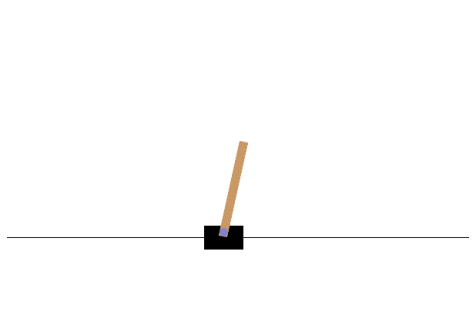

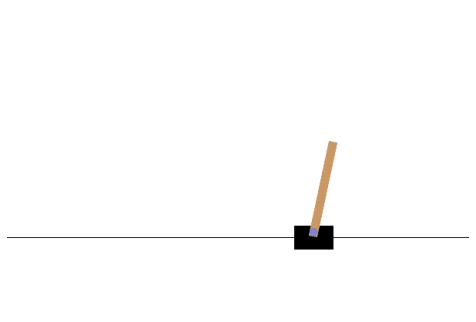

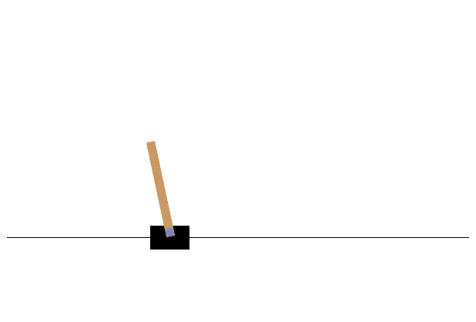

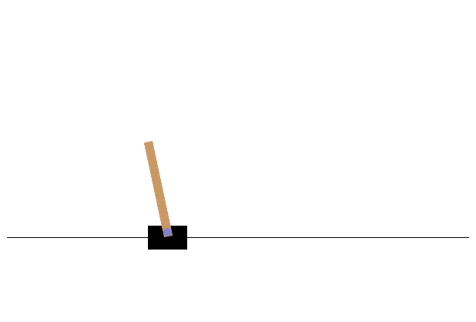

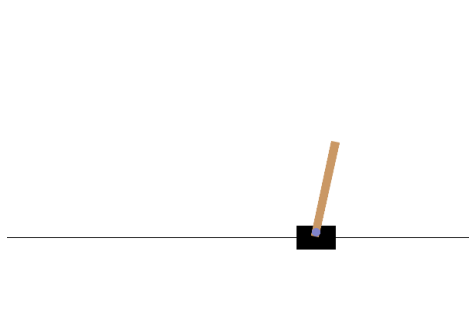

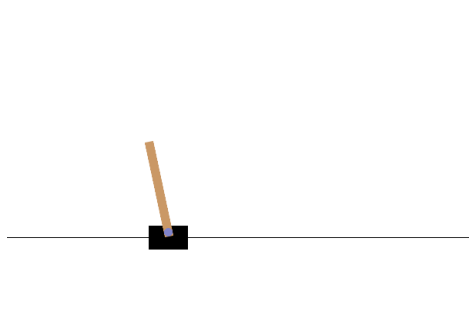

In [29]:
preamble_steps = 5
train_steps = 300
export_num = 5
avg_rets = []

agent.rb.clear()
agent.collect_experience(preamble_steps)

rets, frames = agent.run(1, follow_policy_only=True, export_frames=True)
save_frames_as_gif(frames, filename='cart-pole-ep-0.gif')

for _ in range(train_steps):
    agent.collect_experience(1)
    agent.train(5)
    
    if (_ + 1) % (train_steps / min(train_steps, 500)) == 0:
        avg_rets.append(np.sum(agent.run(6, follow_policy_only=True)) / 6)
    
    if (_ + 1) % (train_steps / export_num) == 0:
        rets, frames = agent.run(1, follow_policy_only=True, export_frames=True)
        save_frames_as_gif(frames, filename='cart-pole-ep-{0}.gif'.format(_ + 1))
        print('rendered')
    
    if (_ + 1) % (train_steps / 10) == 0:
        print(str(_ + 1))

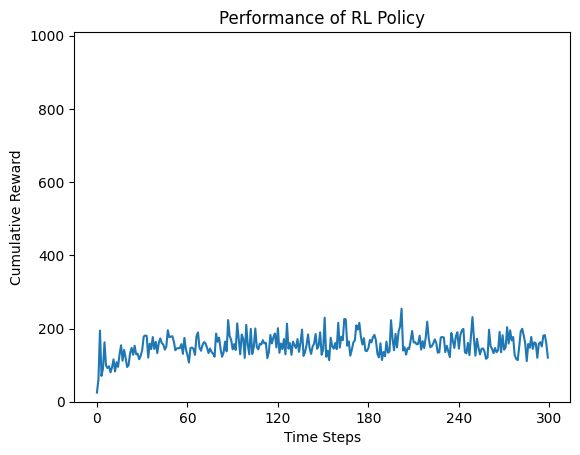

In [30]:
def plot(rets, x_up_bound=1, x_low_bound=0, tick_num=5):
    plt.plot(rets)
    plt.title('Performance of RL Policy')
    plt.xlabel('Time Steps')
    plt.ylabel('Cumulative Reward')
    plt.xticks(ticks=np.arange(0, len(rets) + 1, len(rets) / tick_num, dtype=int), 
               labels=np.arange(x_low_bound, x_up_bound + 1, (x_up_bound - x_low_bound) / tick_num, dtype=int))
    plt.ylim([0, max_steps + 10])
    plt.show()
    
plot(avg_rets, train_steps)

In [24]:
agent.rb.clear()
agent.collect_experience(1, follow_policy_only=True)
np.sum(agent.rb.rewards)

17.0

In [67]:
net = NeuralNetwork(
    Layer(env.observation_space.shape[0], train_bias=False),
    Layer(32, 'relu'),
    Layer(32, 'relu'),
    Layer(1)
)
dqn_opt = SGD(net, lr=0.01)
dqn = DQN(net, dqn_opt, 600)

In [68]:
# print(net)
dqn_train_steps = 300000

for _ in range(dqn_train_steps):
    sample = agent.rb.sample(5, item_wise=False)[:-1]
    dqn.train(*sample, False)
    
    if (_ + 1) % (dqn_train_steps / 10) == 0:
        print(str(_ + 1))
        
    # if (_ + 1) % 5000 == 0:
    #     agent.rb.clear()
    #     agent.collect_experience(1, follow_policy_only=True)
    # dqn.train(*agent.rb.sample(1, item_wise=False)[:-1])
# print(net)
# dqn(sample[0])

30000
60000
90000
120000
150000
180000
210000
240000
270000
300000


In [69]:
done_steps = []
for idx, x in enumerate(agent.rb.dones):
    if x:
        done_steps.append(idx)
if done_steps == []:
    done_steps.append(len(agent.rb.dones) - 1)
done_steps.insert(0, 0)

(1.0, 14.017071989509695)

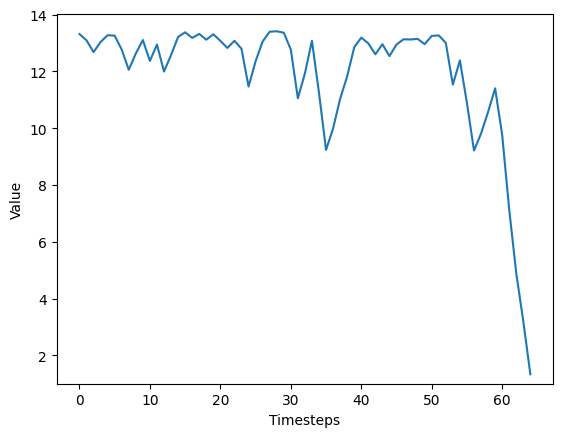

In [72]:
ep = 1
plt.plot(dqn(agent.rb.states[done_steps[ep] + 1:done_steps[ep + 1]]))
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.ylim(1)

In [71]:
print(net)

0: [0.000 0.000 0.000 0.000] -- linear
[[0.950 -0.192 0.204 1.019 0.932 0.892 -0.272 0.099 0.752 0.347 -0.107
  -0.528 0.459 0.283 -0.325 1.116 0.111 0.044 -0.326 0.474 2.791 0.891
  -0.479 0.852 -0.030 0.471 0.681 0.208 -0.665 0.205 -0.043 0.318]
 [-0.676 0.447 -0.915 -1.442 -1.343 0.836 0.656 0.044 -0.454 -0.589 1.383
  0.650 -0.208 0.651 0.843 -1.711 0.855 0.474 -2.129 -0.226 2.690 0.477
  0.114 0.833 -0.020 -0.600 -1.155 -1.386 0.282 0.229 1.424 1.813]
 [4.165 0.723 4.330 -0.616 -0.866 10.053 1.189 0.040 4.376 2.440 2.109
  8.525 2.785 3.029 -0.071 3.336 1.897 1.189 -12.626 2.573 -2.153 -0.594
  1.526 6.294 0.789 2.733 2.672 4.031 2.313 0.186 0.871 11.357]
 [-0.575 0.219 -0.294 0.168 -0.171 2.443 0.504 0.077 -0.885 -0.613 0.793
  1.360 0.262 1.580 0.871 -1.203 0.983 0.253 -3.445 -0.235 1.741 1.592
  -1.108 3.098 -0.051 -0.735 -0.795 -1.005 0.016 0.250 0.938 2.955]]
1: [0.206 -0.134 -0.326 -0.489 -0.552 -1.633 0.175 -0.177 0.433 0.138 -0.212
 -2.045 -0.209 -0.209 0.198 -0.113 -0.025